<a href="https://colab.research.google.com/github/RickStark/Reinforce-Learning-Practice/blob/main/RL_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()

        # Capa compartida (procesa la entrada cruda)
        self.shared_layer = nn.Linear(input_dim, hidden_dim)

        # Cabeza del ACTOR (Input -> Probabilidades de acción)
        self.actor_head = nn.Linear(hidden_dim, action_dim)

        # Cabeza del CRÍTICO (Input -> Un solo valor numérico)
        self.critic_head = nn.Linear(hidden_dim, 1)

    def forward(self):
        # En PPO no solemos usar un forward único estándar,
        # sino métodos separados para actuar y evaluar.
        raise NotImplementedError

    def act(self, state):
        # 1. Pasamos el estado por la capa compartida + activación
        x = F.relu(self.shared_layer(state))

        # 2. El actor calcula los "logits" (valores crudos) de las acciones
        action_logits = self.actor_head(x)

        # 3. Convertimos a probabilidades con Softmax
        # y creamos una distribución para muestrear (stochastic policy)
        dist = Categorical(logits=action_logits)

        # 4. Elegimos una acción basada en las probabilidades
        action = dist.sample()

        # 5. Devolvemos la acción y su log-probabilidad (necesaria para la loss function después)
        return action, dist.log_prob(action)

    def get_value(self, state):
        # El crítico solo quiere estimar el valor
        x = F.relu(self.shared_layer(state))
        value = self.critic_head(x)
        return value

    def evaluate_actions(self, state, action):
        # Paso 1: Pasar por capa compartida
        x = F.relu(self.shared_layer(state))

        # Paso 2: Actor
        action_logits = self.actor_head(x)
        dist = Categorical(logits=action_logits)

        log_probs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        # Paso 3: Crítico
        # Squeeze para asegurar que las dimensiones coincidan (batch,)
        state_values = self.critic_head(x).squeeze()

        return log_probs, dist_entropy, state_values

In [2]:
import gymnasium as gym
import torch.optim as optim

# Hiperparámetros básicos de PPO
lr = 3e-4
gamma = 0.99          # Factor de descuento (qué tanto importan las recompensas futuras)
clip_ratio = 0.2      # El famoso "epsilon" de PPO para recortar cambios drásticos
steps_per_rollout = 2048 # Cuántos pasos jugamos antes de actualizar

env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0] # 4
action_dim = env.action_space.n            # 2

model = ActorCritic(input_dim, action_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [3]:
def collect_trajectories(env, model, steps):
    # Listas para guardar la experiencia
    batch_states = []
    batch_actions = []
    batch_log_probs = []
    batch_rewards = []
    batch_dones = []
    batch_values = []

    state = env.reset()
    if isinstance(state, tuple): state = state[0] # Compatibilidad con Gymnasium nuevo

    for _ in range(steps):

        # Convertir estado a tensor
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        # El modelo decide (sin calcular gradientes para ir rápido)
        with torch.no_grad():
            action, log_prob = model.act(state_tensor)
            value = model.get_value(state_tensor)

        # Ejecutar acción en el entorno
        next_state, reward, done, truncated, _ = env.step(action.item())

        # Guardar datos
        batch_states.append(state_tensor)
        batch_actions.append(action)
        batch_log_probs.append(log_prob)
        batch_rewards.append(reward)
        batch_dones.append(done)
        batch_values.append(value)

        state = next_state

        if done or truncated:
          state = env.reset()
          if isinstance(state, tuple): state = state[0]




    return batch_states, batch_actions, batch_log_probs, batch_rewards, batch_dones, batch_values

In [4]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, lam=0.95):
    # Convertimos todo a listas de valores simples para iterar rápido
    # values es la salida del Crítico

    values = values + [next_value] # Añadimos el valor del último estado para el cálculo
    gae = 0
    returns = []

    # Iteramos hacia atrás (desde el último paso hasta el primero)
    for step in reversed(range(len(rewards))):
        # Delta: Recompensa + (Valor futuro descontado si no terminó) - Valor actual
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]

        # GAE: Delta actual + (GAE anterior descontado por gamma y lambda)
        gae = delta + gamma * lam * masks[step] * gae

        # El retorno objetivo es: lo que predijo el crítico + la ventaja real calculada
        returns.insert(0, gae + values[step])

    return returns

In [5]:
def ppo_update(model, optimizer, epochs, batch_size, states, actions, old_log_probs, returns, advantages):

    # Convertimos listas a tensores para PyTorch
    states = torch.cat(states)
    actions = torch.cat(actions)
    old_log_probs = torch.cat(old_log_probs).detach() # Importante: detach para que sean constantes
    returns = torch.tensor(returns).float()
    advantages = torch.tensor(advantages).float()

    # Normalizamos las ventajas (Truco clave para estabilidad)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Bucle de optimización (PPO permite re-usar los datos varias veces/epochs)
    n_samples = states.size(0)
    for _ in range(epochs):
        # Generamos índices aleatorios para mini-batches
        indices = torch.randperm(n_samples)

        for start in range(0, n_samples, batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]

            # 1. Obtenemos log_probs y valores NUEVOS con la red actual
            # Aquí llamamos al modelo de nuevo sobre los estados guardados
            # (Ojo: implementaremos evaluate_actions en la clase ActorCritic abajo para facilitar esto)
            new_log_probs, entropy, new_values = model.evaluate_actions(states[batch_idx], actions[batch_idx])

            # 2. Calculamos el RATIO (Probabilidad Nueva / Probabilidad Vieja)
            # Como trabajamos con logaritmos, dividimos restando y aplicando exp
            ratio = (new_log_probs - old_log_probs[batch_idx]).exp()

            # 3. Calculamos la Loss del Actor (Policy Loss)
            surr1 = ratio * advantages[batch_idx]
            surr2 = torch.clamp(ratio, 1.0 - 0.2, 1.0 + 0.2) * advantages[batch_idx] # Clip ratio 0.2
            actor_loss = -torch.min(surr1, surr2).mean()

            # 4. Calculamos la Loss del Crítico (Value Loss - MSE)
            critic_loss = (returns[batch_idx] - new_values).pow(2).mean()

            # 5. Loss Total (A veces añadimos entropía para fomentar exploración)
            total_loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy.mean()

            # 6. Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Listas para guardar métricas para la gráfica
score_history = []
loss_history = []  # Opcional, si quisieras guardar la loss también

# Hiperparámetros
MAX_EPISODES = 2000  # Puedes bajarlo a 200 para probar rápido
STEPS_PER_ROLLOUT = 2048
EPOCHS = 4
BATCH_SIZE = 64

print("Iniciando entrenamiento...")

for episode in range(MAX_EPISODES):
    # 1. Recolectar datos
    states, actions, log_probs, rewards, dones, values = collect_trajectories(env, model, STEPS_PER_ROLLOUT)

    # 2. Calcular GAE
    last_state = states[-1]
    with torch.no_grad():
        _, _, next_val = model.evaluate_actions(last_state, actions[-1])

    masks = [1 - d for d in dones]
    next_value_scalar = next_val.item()
    returns = compute_gae(next_value_scalar, rewards, masks, [v.item() for v in values])

    values_tensor = torch.tensor([v.item() for v in values])
    returns_tensor = torch.tensor(returns)
    advantages = returns_tensor - values_tensor

    # 3. Actualizar red
    ppo_update(model, optimizer, EPOCHS, BATCH_SIZE, states, actions, log_probs, returns, advantages)

    # 4. Calcular Score y Guardar en Historial
    n_dones = sum(dones)

    if n_dones > 0:
        avg_score = sum(rewards) / n_dones
    else:
        # Si no murió ninguna vez, el score es el máximo posible del rollout
        avg_score = STEPS_PER_ROLLOUT

    score_history.append(avg_score) # <--- GUARDAMOS EL DATO AQUÍ

    # Log cada 10 actualizaciones para no ensuciar la consola
    if episode % 10 == 0:
        print(f"Update {episode} | Avg Score: {avg_score:.2f}")

    # Condición de victoria (CartPole suele ser > 475)
    if len(score_history) > 10 and np.mean(score_history[-10:]) >= 475:
        print(f"¡Resuelto en el update {episode}!")
        break

env.close()

Iniciando entrenamiento...
Update 0 | Avg Score: 25.00


/tmp/ipython-input-710443064.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  advantages = torch.tensor(advantages).float()


Update 10 | Avg Score: 206.00
Update 20 | Avg Score: 86.00
Update 30 | Avg Score: 95.00
Update 40 | Avg Score: 71.00
Update 50 | Avg Score: 248.00
Update 60 | Avg Score: 120.00
Update 70 | Avg Score: 48.00
Update 80 | Avg Score: 235.00
Update 90 | Avg Score: 159.00
Update 100 | Avg Score: 211.00
Update 110 | Avg Score: 190.00
Update 120 | Avg Score: 50.00
Update 130 | Avg Score: 317.00
Update 140 | Avg Score: 298.00
Update 150 | Avg Score: 173.00
Update 160 | Avg Score: 137.00
Update 170 | Avg Score: 295.00
Update 180 | Avg Score: 159.00
Update 190 | Avg Score: 117.00
Update 200 | Avg Score: 102.00
Update 210 | Avg Score: 127.00
Update 220 | Avg Score: 86.00
Update 230 | Avg Score: 51.00
Update 240 | Avg Score: 120.00
Update 250 | Avg Score: 2048.00
Update 260 | Avg Score: 110.00
Update 270 | Avg Score: 334.00
Update 280 | Avg Score: 201.00
Update 290 | Avg Score: 267.00
Update 300 | Avg Score: 135.00
Update 310 | Avg Score: 51.00
Update 320 | Avg Score: 132.00
Update 330 | Avg Score: 

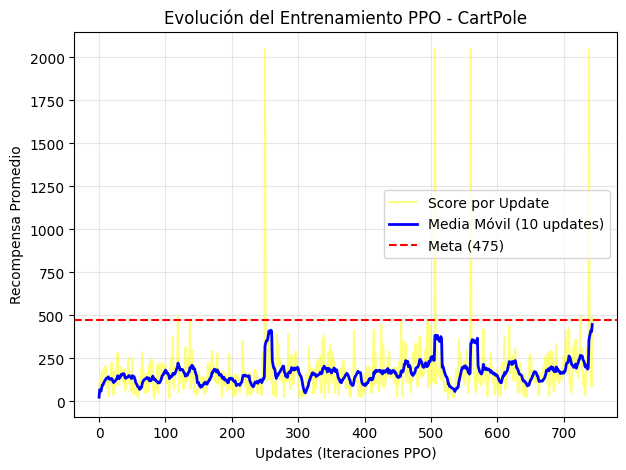

In [9]:
def plot_learning_curve(scores, window=10):
    # Calcular media móvil para suavizar
    moving_avg = []
    for i in range(len(scores)):
        start = max(0, i - window)
        moving_avg.append(np.mean(scores[start:i+1]))

    plt.figure(figsize=(7, 5))

    # Gráfica de datos crudos (transparente)
    plt.plot(scores, label='Score por Update', color='yellow', alpha=0.5)

    # Gráfica de tendencia (fuerte)
    plt.plot(moving_avg, label=f'Media Móvil ({window} updates)', color='blue', linewidth=2)

    plt.title('Evolución del Entrenamiento PPO - CartPole')
    plt.xlabel('Updates (Iteraciones PPO)')
    plt.ylabel('Recompensa Promedio')
    plt.axhline(y=475, color='r', linestyle='--', label='Meta (475)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Ejecutar función
plot_learning_curve(score_history)

In [10]:
# Guardar los pesos
torch.save(model.state_dict(), 'ppo_cartpole_solved.pth')
print("Modelo guardado exitosamente como 'ppo_cartpole_solved.pth'")

Modelo guardado exitosamente como 'ppo_cartpole_solved.pth'


In [14]:
from gymnasium.wrappers import RecordVideo

# Crear entorno con grabación
env = gym.make('CartPole-v1', render_mode='rgb_array')
# trigger=lambda x: True graba TODOS los episodios.
env = RecordVideo(env, video_folder='./video_ppo', episode_trigger=lambda x: True)

model.eval()

print("Grabando 10 episodios...")

# 2. Bucle para ejecutar 10 episodios
for i in range(10):
    # En Gymnasium reset() devuelve (state, info) siempre
    state, _ = env.reset()

    done = False
    truncated = False
    total_reward = 0

    while not done and not truncated:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
            action, _ = model.act(state_tensor)

        # Paso en el entorno
        state, reward, terminated, truncated, _ = env.step(action.item())

        # Actualizamos flags
        done = terminated or truncated
        total_reward += reward

    print(f"Episodio {i+1} finalizado. Score: {total_reward}")

# 3. Cerrar entorno para finalizar la escritura de archivos de video
env.close()
print("¡Todos los videos guardados en la carpeta './video_ppo'!")

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/video_ppo folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Grabando 10 episodios...
Episodio 1 finalizado. Score: 138.0
Episodio 2 finalizado. Score: 168.0
Episodio 3 finalizado. Score: 313.0
Episodio 4 finalizado. Score: 483.0
Episodio 5 finalizado. Score: 274.0
Episodio 6 finalizado. Score: 375.0
Episodio 7 finalizado. Score: 457.0
Episodio 8 finalizado. Score: 88.0
Episodio 9 finalizado. Score: 223.0
Episodio 10 finalizado. Score: 355.0
¡Todos los videos guardados en la carpeta './video_ppo'!
